# MPG Prediction Using Halved Neural Network

In [1]:
import numpy as np
import seaborn as sb
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import tree
from keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.neighbors import KNeighborsRegressor
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import concatenate
from ann_visualizer.visualize import ann_viz
from keras.callbacks import EarlyStopping
from keras.models import load_model

%matplotlib inline
%config InlineBackend.figure_format = 'svg'


Using TensorFlow backend.


In [2]:
showGraphs = True
randomSeed = 12346
np.random.seed(randomSeed)
EPOCHS = 500

In [3]:
data = pd.read_csv('mpg.csv')  # read MPG csv data
data = data[data['horsepower'] != '?']   # remove entries with unknown horsepower
data = data[['mpg', 'displacement', 'cylinders', 'horsepower', 'weight']]   # take only mpg, weight, cylinders...
data = data.apply(lambda col: col.astype(np.float64))   # convert everything to float
data = data[~((data['horsepower'] == 132) & (data['mpg'] == 32.7))] # outlier1
data = data[~((data['displacement'] == 262) & (data['mpg'] == 38))] # outlier2

In [4]:
if (showGraphs):
    data.head()

## Data Visualisation

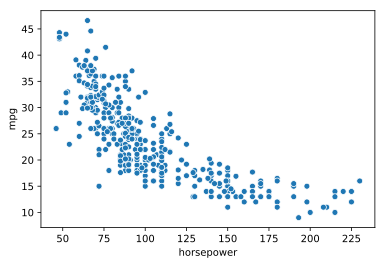

In [5]:
if (showGraphs):
    _ = sb.scatterplot(data=data, x='horsepower', y='mpg')

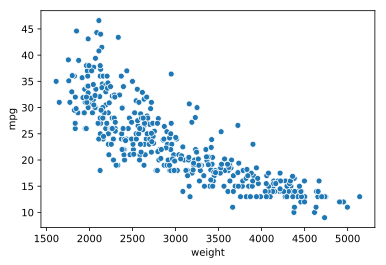

In [6]:
if (showGraphs):
    _ = sb.scatterplot(data=data, x='weight', y='mpg')

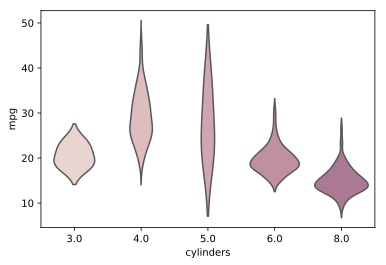

In [7]:
if (showGraphs):
    _ = sb.violinplot(data=data, x='cylinders', y='mpg', palette=sb.cubehelix_palette(10), inner=None)

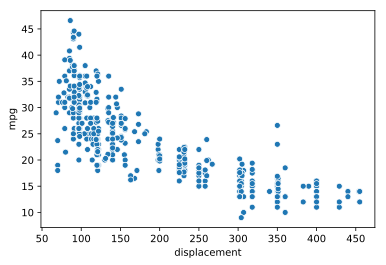

In [8]:
if (showGraphs):
    _ = sb.scatterplot(data=data, x='displacement', y='mpg')

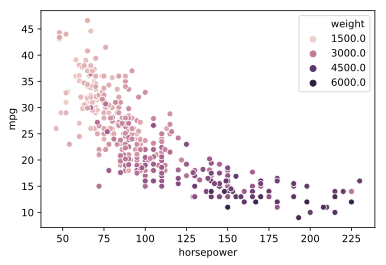

In [9]:
if (showGraphs):
    _ = sb.scatterplot(data=data, x='horsepower', y='mpg', hue='weight')

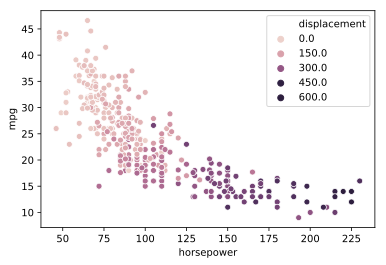

In [10]:
if (showGraphs):
    _ = sb.scatterplot(data=data, x='horsepower', y='mpg', hue='displacement')

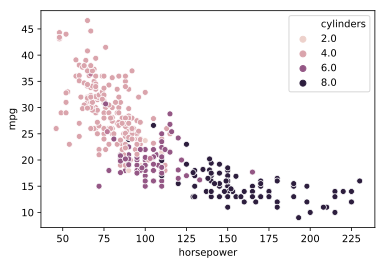

In [11]:
if (showGraphs):
    _ = sb.scatterplot(data=data, x='horsepower', y='mpg', hue='cylinders')

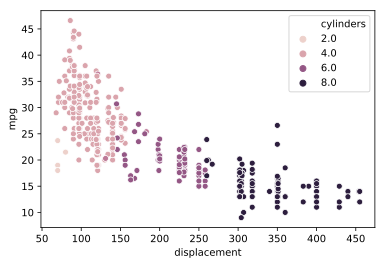

In [12]:
if (showGraphs):
    _ = sb.scatterplot(data=data, x = 'displacement', y='mpg', hue='cylinders')

### Correlation Matrix

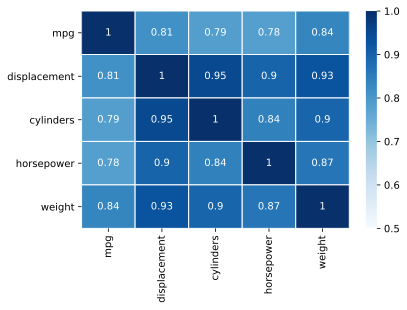

In [25]:
if (showGraphs):
    _ = sb.heatmap(abs(data.corr()), annot = True, linewidth=1.0, cmap="Blues", vmin=0.5, vmax=1.0)

## MPG Prediction

### Test  Data Precent = 20%

In [14]:
testPrecent = 0.2
trainPrecent = 1.0 - testPrecent
trainData = data.sample(frac=trainPrecent, random_state=randomSeed)
testData = data.drop(trainData.index)

trainLabels = trainData.pop('mpg')
testLabels = testData.pop('mpg')


### Normalize Data

In [15]:
trainStats = trainData.describe().T
def normalize(x):
    return (x - trainStats['mean']) / trainStats['std']
trainData = normalize(trainData)
testData = normalize(testData)

In [16]:
def errorEvaluation(error):
    mae = np.mean(abs(error))
    mse = np.mean(error * error)
    return mae, mse

def fitPredict(model):
    model.fit(trainData, trainLabels)
    predicted = model.predict(testData)
    return errorEvaluation(testLabels - predicted)
   # print(modelName + ':')
   # print("\tMSE = {:5.2f}".format(mse))
    #print("\tMAE = {:5.2f}".format(mae))

### Linear Regression

In [17]:
print('Linear Regression')
linearMae, linearMse = fitPredict(linear_model.LinearRegression())
print ('mse = ' + str(linearMse))
print ('mae = ' + str(linearMae))

Linear Regression
mse = 16.940666532824512
mae = 3.2571378760024854


### K Nearset Neighbors

In [18]:
knnResults = dict()
for neighbors in range(2, 17):
    knnResults[neighbors] = list(fitPredict(KNeighborsRegressor(n_neighbors = neighbors)))
knnResults = pd.DataFrame(knnResults).T.rename(columns={0: "MAE", 1: "MSE"})
if (showGraphs):
    knnResults

In [19]:
knnMse = min(knnResults['MSE'])
knnMae = min(knnResults['MAE'])
print("KNN best MSE: " + str(knnMse))
print("KNN best MAE: " + str(knnMae))
print("Best K = " + str(knnResults.sort_values(by = 'MSE').head(1).index[0]))


KNN best MSE: 18.21270180436847
KNN best MAE: 3.043846153846154
Best K = 9


### Decision Tree

In [20]:
decResults = dict()
for maxDepth in range(2, 17):
    decResults[maxDepth] = list(fitPredict(tree.DecisionTreeRegressor(max_depth=maxDepth, random_state=randomSeed)))
decResults = pd.DataFrame(decResults).T.rename(columns={0: "MAE", 1: "MSE"})
if (showGraphs):
    decResults

In [21]:
decMse = min(decResults['MSE'])
decMae = min(decResults['MAE'])
print("Decision Tree best MSE " + str(decMse))
print("Decision Tree best MAE " + str(decMae))
print("Best Tree Depth = " + str(decResults.sort_values(by = 'MSE').head(1).index[0]))

Decision Tree best MSE 18.136572842257728
Decision Tree best MAE 3.020510583483454
Best Tree Depth = 5


### Fully Connected Neural Network Model

In [22]:
def build_fully_NN_model(train):
    model = Sequential()
    model.add(Dense(10, activation='relu', input_dim=len(train.keys())))
   # model.add(Dense(10, activation='relu'))
    model.add(Dense(1))
    
  
    model.compile(loss='mean_squared_error',
                optimizer='adam',
                metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

In [23]:
fully_NN_model = build_fully_NN_model(trainData)

In [24]:
if (showGraphs):
    fully_NN_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                50        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


In [25]:
if (showGraphs):
    plot_model(fully_NN_model, to_file='fullyNN.png')

In [26]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

def trainModel(model, X, Y):
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=100)
    mc = ModelCheckpoint('best_nn_model.nn', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
    history = model.fit(X, Y, epochs=EPOCHS, validation_split = 0.2, verbose=0, callbacks=[PrintDot(), es, mc])
    model = load_model('best_nn_model.nn')
    return history, model

In [27]:
fully_NN_history, fully_NN_model = trainModel(fully_NN_model, trainData, trainLabels)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

In [28]:
hist = pd.DataFrame(fully_NN_history.history)
hist['epoch'] = fully_NN_history.epoch

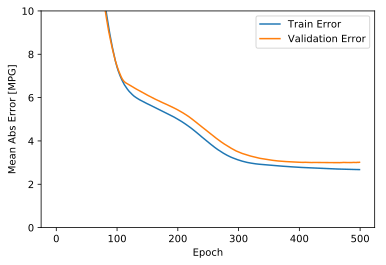

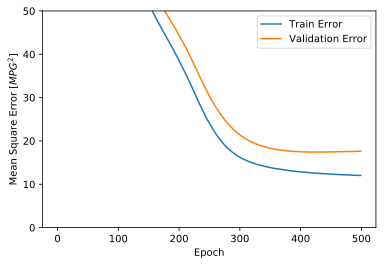

In [29]:
def plot_history(history):    
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'], label = 'Validation Error')
  plt.ylim([0,10])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'], label = 'Validation Error')
  plt.ylim([0,50])
  plt.legend()
  plt.show()


if (showGraphs):
    plot_history(fully_NN_history)

In [30]:
def show_test_predictions(name, model, testX, testY):
    loss, mae, mse = model.evaluate(testX, testY, verbose=0)
    print(name + ' MSE: ' + str(fullyMse))
    print(name + ' MAE: ' + str(fullyMae))
    if (showGraphs):
        test_predictions = model.predict(testX).flatten()

        plt.scatter(testY, test_predictions)
        plt.xlabel('True Values [MPG]')
        plt.ylabel('Predictions [MPG]')
        plt.axis('equal')
        plt.axis('square')
        plt.xlim([0,plt.xlim()[1]])
        plt.ylim([0,plt.ylim()[1]])
        _ = plt.plot([0, 100], [0, 100])
    return mse, mae

Fully Connected NN MSE: 0
Fully Connected NN MAE: 2


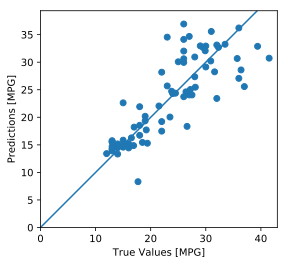

In [31]:
fullyMse = 0
fullyMae = 2
fullyMse, fullyMae = show_test_predictions('Fully Connected NN', fully_NN_model, testData, testLabels)

### Halved Neural Network Model

In [32]:
def buildHalvedModel():
    input1 = Input(shape=(2,))
    hidden1_1 = Dense(5, activation='relu')(input1)
   # hidden1_2 = Dense(5, activation='relu')(hidden1_1)
    out1 = Dense(1, activation='relu')(hidden1_1)
    
    input2 = Input(shape=(2,))
    hidden2_1 = Dense(5, activation='relu')(input2)
   # hidden2_2 = Dense(5, activation='relu')(hidden2_1)
    out2 = Dense(1, activation='relu')(hidden2_1)
    
    merge = concatenate([out1, out2])
    output = Dense(1)(merge)
    
    model = Model(inputs=[input1, input2], outputs=output)
    
    model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mean_absolute_error', 'mean_squared_error'])
    
    return model

In [33]:
modelsSplits = [[['displacement', 'cylinders'] , ['horsepower', 'weight']],
                [['displacement', 'horsepower'], ['cylinders', 'weight']],
                [['displacement', 'weight']     , ['horsepower', 'cylinders']]]

halvedModels = [buildHalvedModel(), buildHalvedModel(), buildHalvedModel()]


def splitModelsData(data):
    return list(map(lambda split: [data[split[0]], data[split[1]]], modelsSplits))

modelsTrain = splitModelsData(trainData)
modelsTest = splitModelsData(testData)

halvedModelsHistories = []

def train(i):
    history, halvedModels[i] = trainModel(halvedModels[i], modelsTrain[i], trainLabels)
    halvedModelsHistories.append(history)

In [34]:
if (showGraphs):
    plot_model(halvedModels[0], to_file='halvedNN.png')

In [35]:
train(0)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

In [36]:
train(1)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

In [37]:
train(2)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

[['displacement', 'cylinders'], ['horsepower', 'weight']]


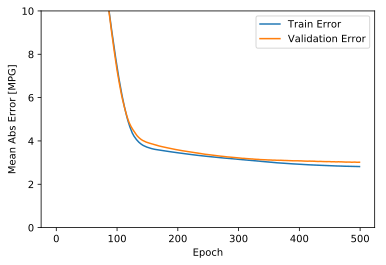

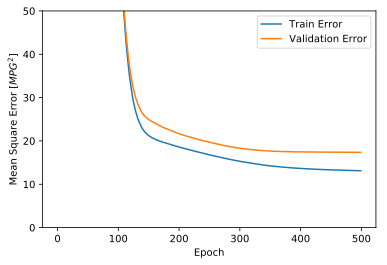

In [38]:
print(modelsSplits[0])

if (showGraphs):
    plot_history(halvedModelsHistories[0])

[['displacement', 'horsepower'], ['cylinders', 'weight']]


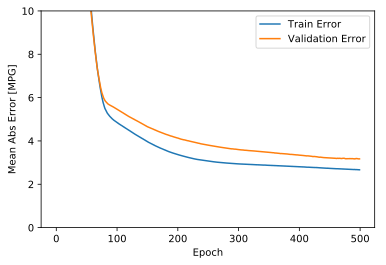

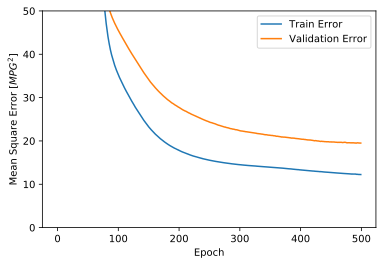

In [39]:
print(modelsSplits[1])

if (showGraphs):
    plot_history(halvedModelsHistories[1])

[['displacement', 'weight'], ['horsepower', 'cylinders']]


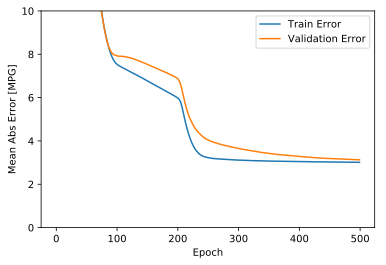

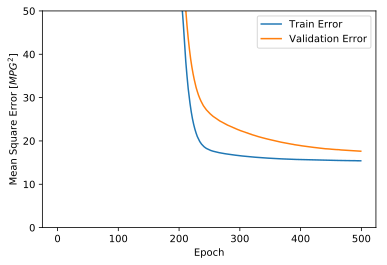

In [40]:
print(modelsSplits[2])

if (showGraphs):
    plot_history(halvedModelsHistories[2])

[['displacement', 'cylinders'], ['horsepower', 'weight']]
Halved Connected NN MSE: 19.48125457763672
Halved Connected NN MAE: 3.181258201599121


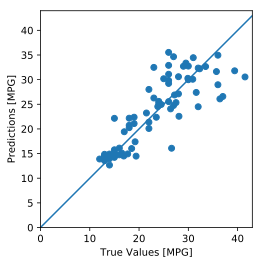

In [41]:
print(modelsSplits[0])
(halved0Mse, halved0Mae) = show_test_predictions('Halved Connected NN', halvedModels[0], modelsTest[0], testLabels)

[['displacement', 'horsepower'], ['cylinders', 'weight']]
Halved Connected NN MSE: 19.48125457763672
Halved Connected NN MAE: 3.181258201599121


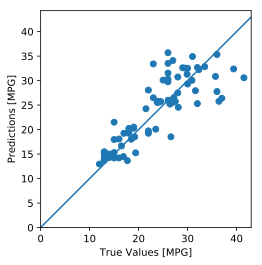

In [42]:
print(modelsSplits[1])
(halved1Mse, halved1Mae) = show_test_predictions('Halved Connected NN', halvedModels[1], modelsTest[1], testLabels)

[['displacement', 'weight'], ['horsepower', 'cylinders']]
Halved Connected NN MSE: 19.48125457763672
Halved Connected NN MAE: 3.181258201599121


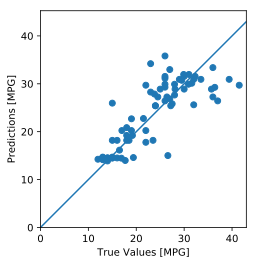

In [43]:
print(modelsSplits[2])
(halved2Mse, halved2Mae) = show_test_predictions('Halved Connected NN', halvedModels[2], modelsTest[2], testLabels)

## Summary

In [44]:
errorParameters = pd.DataFrame({
    0 : ['Decision Tree', decMae, decMse],
    1 : ['Linear Regression', linearMae, linearMse],
    2 : ['KNN', knnMae, knnMse],
    3 : ['Fully connected NN', fullyMae, fullyMse],
    4 : ['Halved0 NN ' + str(modelsSplits[0]), halved0Mae, halved0Mse],
    5 : ['Halved1 NN ' + str(modelsSplits[1]), halved1Mae, halved1Mse],
    6 : ['Halved2 NN ' + str(modelsSplits[2]), halved2Mae, halved2Mse]
}, index = ['Classifier', 'MAE', 'MSE']).T

pd.set_option('display.max_colwidth', 0)
errorParameters

,Classifier,MAE,MSE
0,Decision Tree,3.02051,18.1366
1,Linear Regression,3.25714,16.9407
2,KNN,3.04385,18.2127
3,Fully connected NN,3.18126,19.4813
4,"Halved0 NN [['displacement', 'cylinders'], ['horsepower', 'weight']]",2.99261,17.2641
5,"Halved1 NN [['displacement', 'horsepower'], ['cylinders', 'weight']]",2.98573,16.8599
6,"Halved2 NN [['displacement', 'weight'], ['horsepower', 'cylinders']]",3.0657,18.893


In [45]:
# visualize this table